# 第9章　モデルへの外部変数の追加

ここまで予測に使ってきたモデル

→時系列の過去の値を未来の予測するための説明変数として使っていた

SARIMAXモデル

→時系列を予測するときに外部変数Xを考慮できる



内生変数

モデルの中で説明・予測の対象になる変数

外生変数

モデルの外から与えられる説明変数

$$GDP = C + G + I + NX$$


消費$C$ 政府支出$G$ 投資$I$ 純輸出高$NX$

失業率、金利、為替レートなどの外部変数が影響を与える可能性がある


## 9.1　SARIMAXモデルを調べる

SARIMAモデル

$$
Φ(L^s
 )ϕ(L)(1−L)^d
 (1−L^s
 )^D
 y_t
 =C+Θ(L^s
 )θ(L)ε_t
​$$

$
ϕ(x):=1−\sum_{i=1}^{p}\phi_ix^i
$

$
Φ(x)=1-
\sum_{i}^{p}
Φ_i
x^i
$

$
θ(x):=1+
\sum_{i=1}^{q}
 θ_i
 x^i
$

$
Θ(x)=1+
\sum_{i}^{Q}
Θ_i
x_i
$

SARIMAXモデル

$$
Φ(L^s
 )ϕ(L)(1−L)^d
 (1−L^s
 )^D
 y_t
 =Θ(L^s
 )θ(L)ε_t+β_0+β^Tx_t
​$$

$x_t$ : 外生変数のベクトル

$β$ : 外生変数に対応する回帰係数ベクトル

### 9.1.1 アメリカのマクロ経済データセットの外生変数

In [ ]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


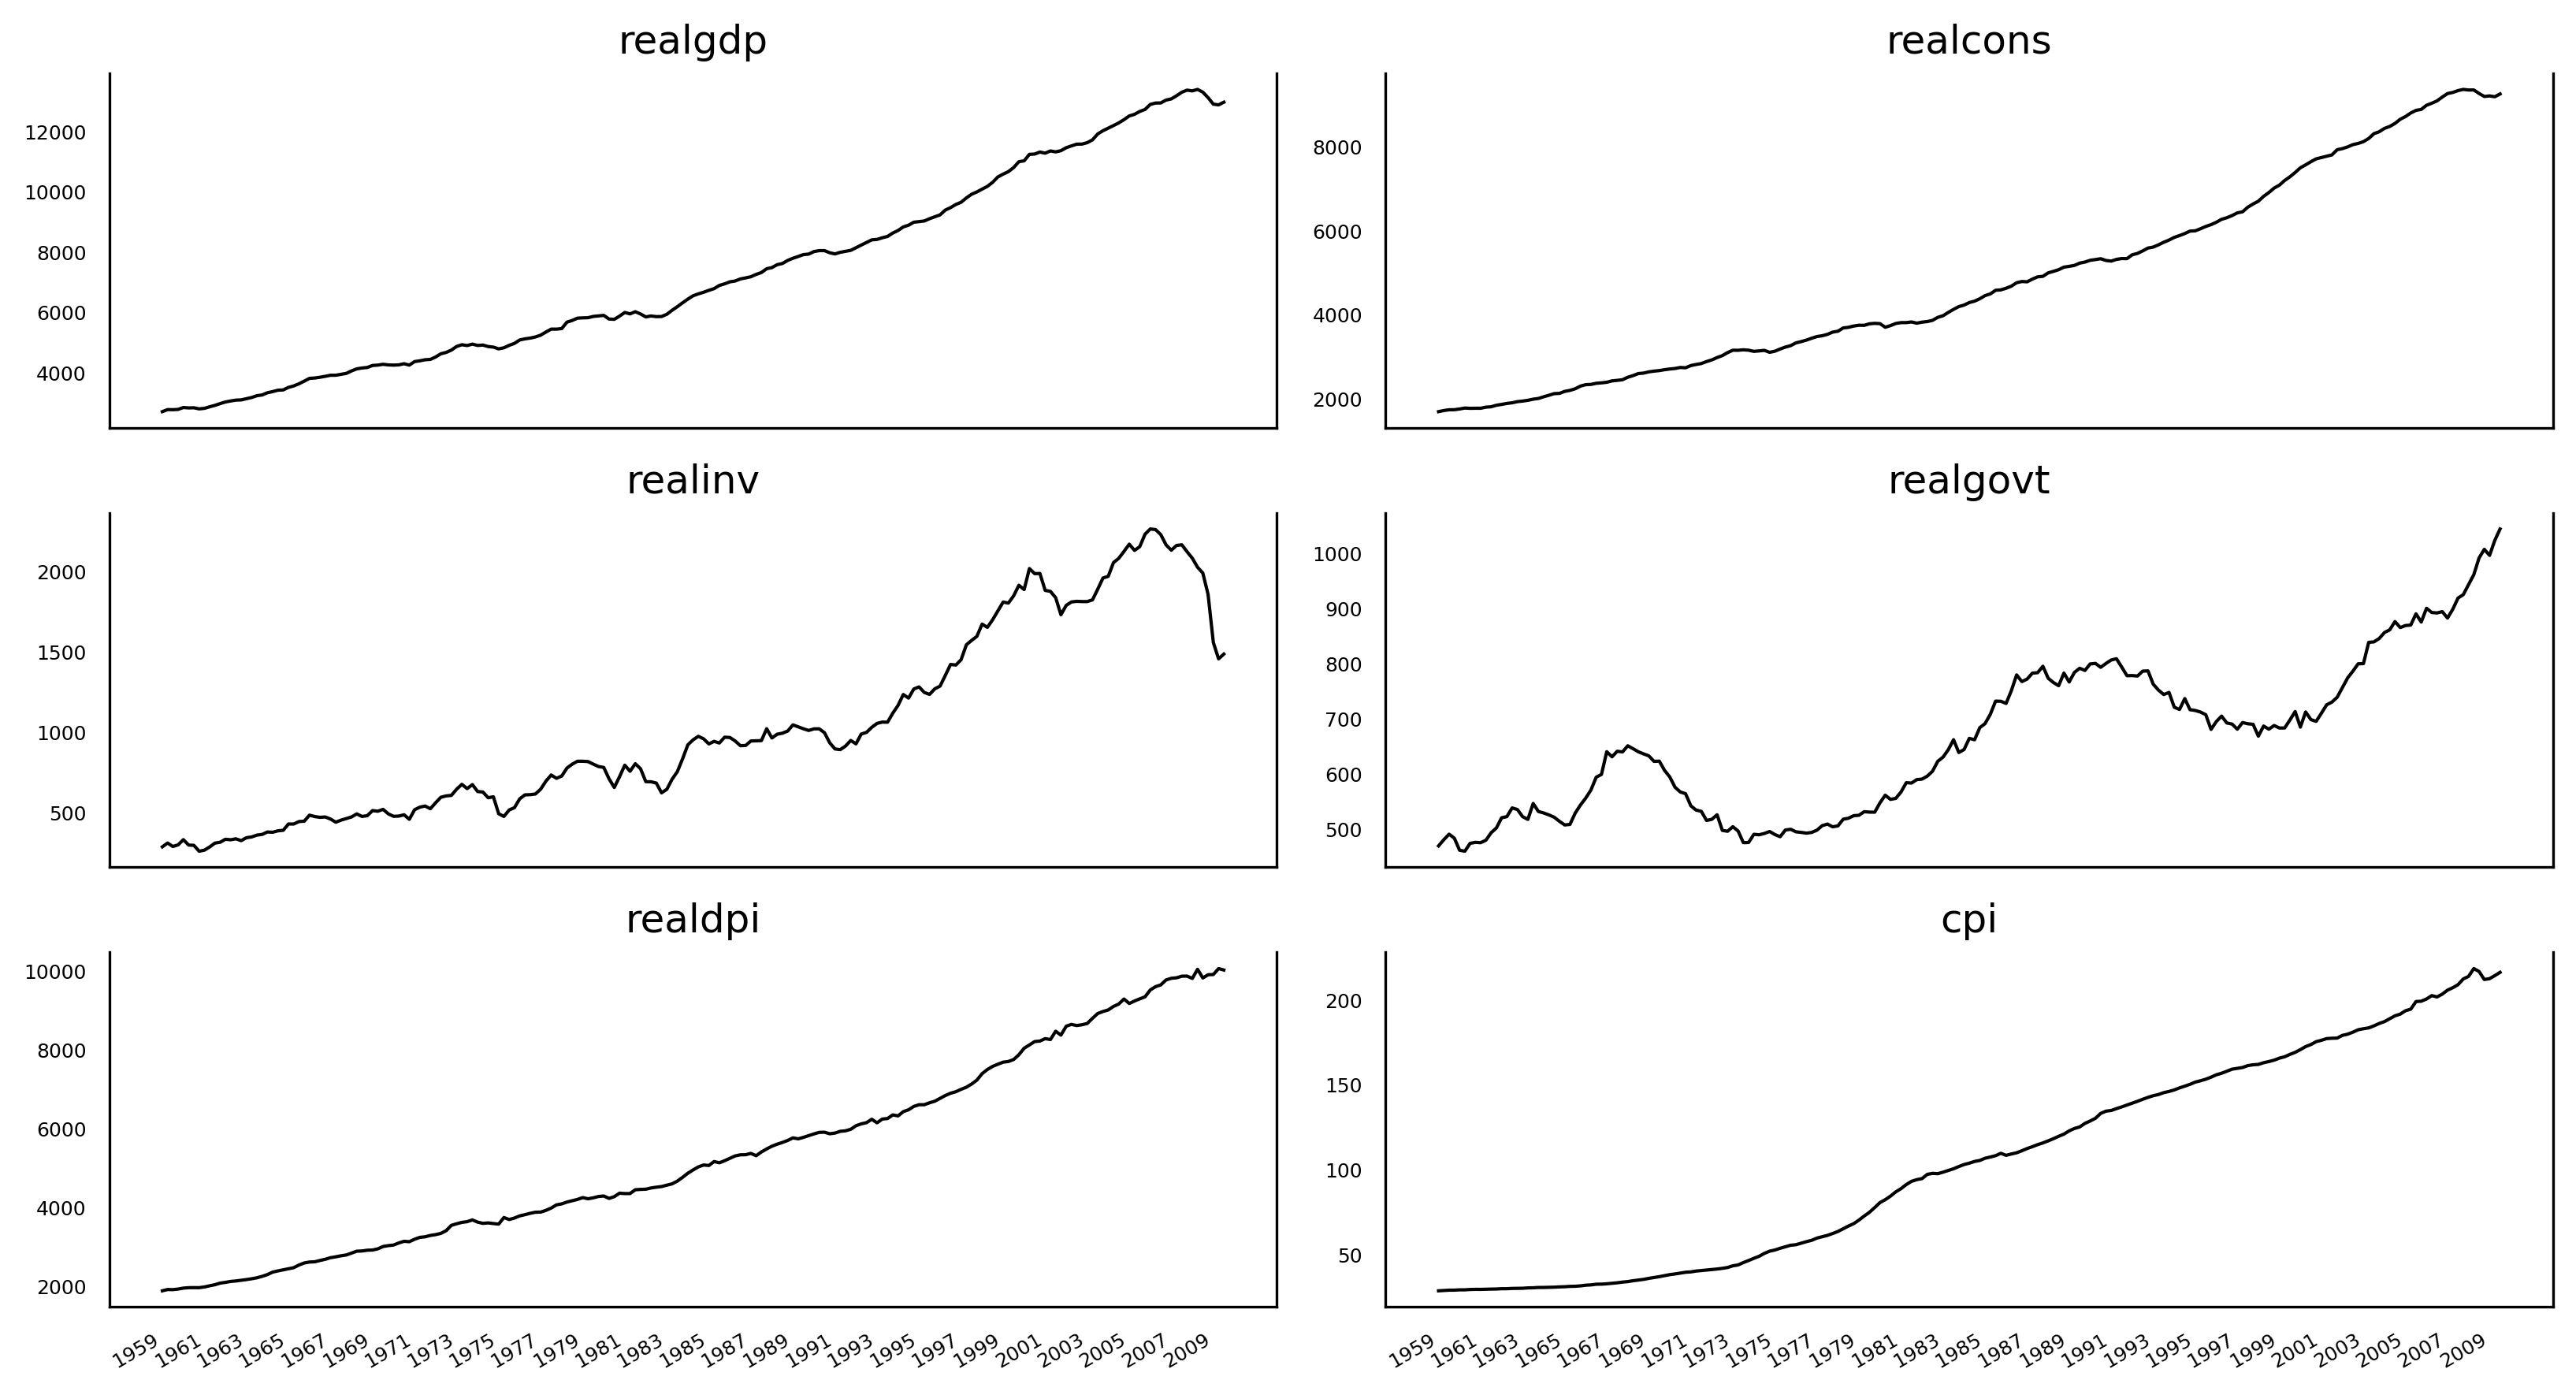

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11, 6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8),
         xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

*   realgdp：実質国内総生産
*   realcons：実質個人消費支出
*   realinv：実質国内総投資額
*   realgovt：連邦政府の実質消費支出および投資額
*   realdpi：実質個人可処分所得
*   cpi：四半期末消費者物価指数

realcoins、realdpi、cpiがよい説明変数である可能性を示唆

時系列予測に外生変数を使う方法
*   外生変数の様々な組み合わせを使って複数のモデルを訓練し、最も良い予測値を生成するものを確認する
* すべての外生変数を組み込み、AICを使ったモデル選択を行う

### 9.1.2　SARIMAXを使うときの注意点

* 予測に用いる外生変数が必要

 (未来の外生変数が既知なら問題ないが、未知の場合は、

 別のSARIMAモデルで外部変数の予測も必要になる)

* また、その予測による誤差に伴って、目的変数の予測誤差が拡大する可能性がある

 (未来の時間ステップが多いほど予測精度が低下)

* 外生変数の将来値が「容易に・正確に」予測できる時に

 SARIMAXを使った長期予測が有効

# 9.2　SARIMAXモデルを使って実質GDPを予測する

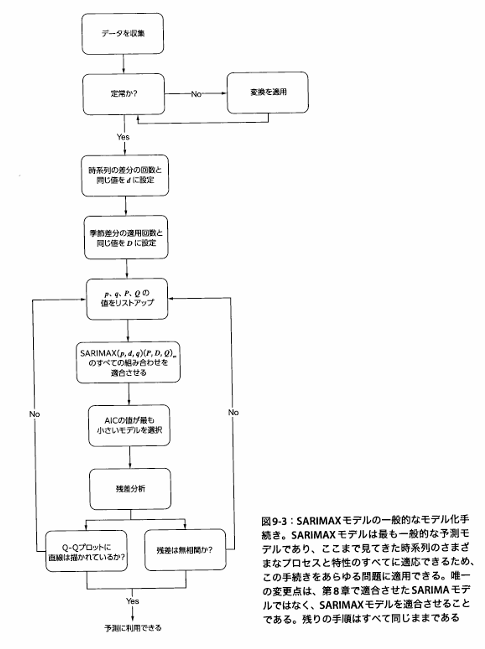

In [ ]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [ ]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_test = adfuller(target)
print(f'ADF Statistic: {ad_fuller_test[0]}')
print(f'p-value: {ad_fuller_test[1]}')

ADF Statistic: 1.7504627967647144
p-value: 0.9982455372335032


In [ ]:
target_diff = np.diff(target,n=1)

ad_fuller_result = adfuller(target_diff[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.304002185140163
p-value: 3.3581293218176396e-08


d=1、D=0で定常化される

optimize_SARIMAX関数を実行し、AICの値が最も小さいモデルを選択

In [ ]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

def optimize_SARIMAX(endog: Union[pd.Series, np.ndarray],
                     exog: Union[pd.Series,pd.DataFrame , np.ndarray, None],
                     order_list: list,
                     d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            if exog is not None:
                model = SARIMAX(endog,
                                exog=exog,
                                order=(order[0], d, order[1]),
                                seasonal_order=(order[2], D, order[3], s),
                                simple_differencing=False).fit(disp=False)
            else:
                model = SARIMAX(endog,
                                order=(order[0], d, order[1]),
                                seasonal_order=(order[2], D, order[3], s),
                                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

ACF と PACF のプロットから、SARIMAX や ARIMA モデルのパラメータ範囲（p, q, P, Q）を 絞る

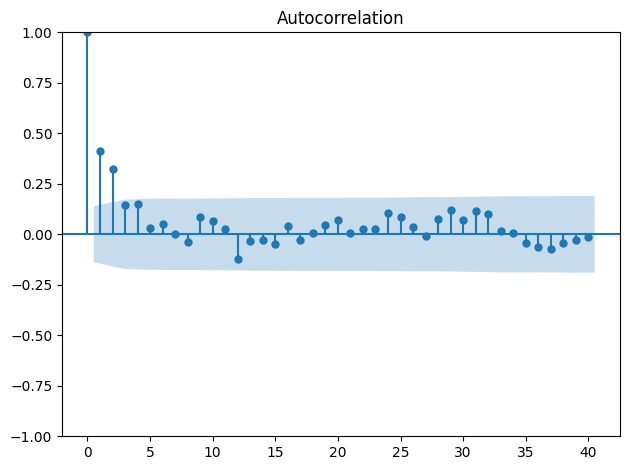

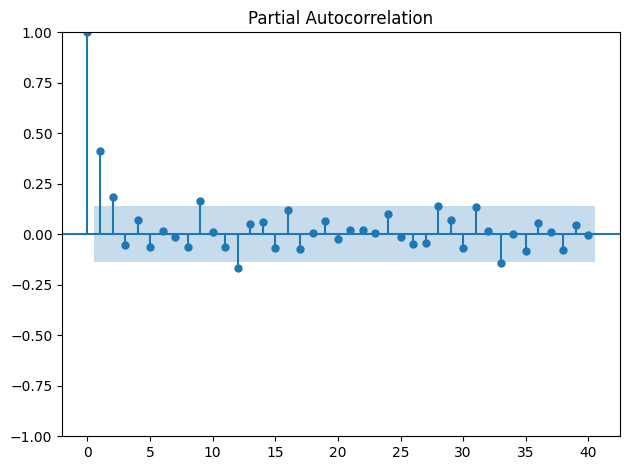

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(target_diff, lags=40)
plt.tight_layout()

plot_pacf(target_diff, lags=40)
plt.tight_layout()

In [ ]:
from itertools import product

p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 2, 1)
Q = range(0, 2, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824529
1,"(3, 3, 1, 0)",1744.967468
2,"(3, 3, 0, 1)",1744.997679
3,"(2, 2, 0, 0)",1745.474959
4,"(2, 2, 0, 1)",1746.457968


In [ ]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3),
                     seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

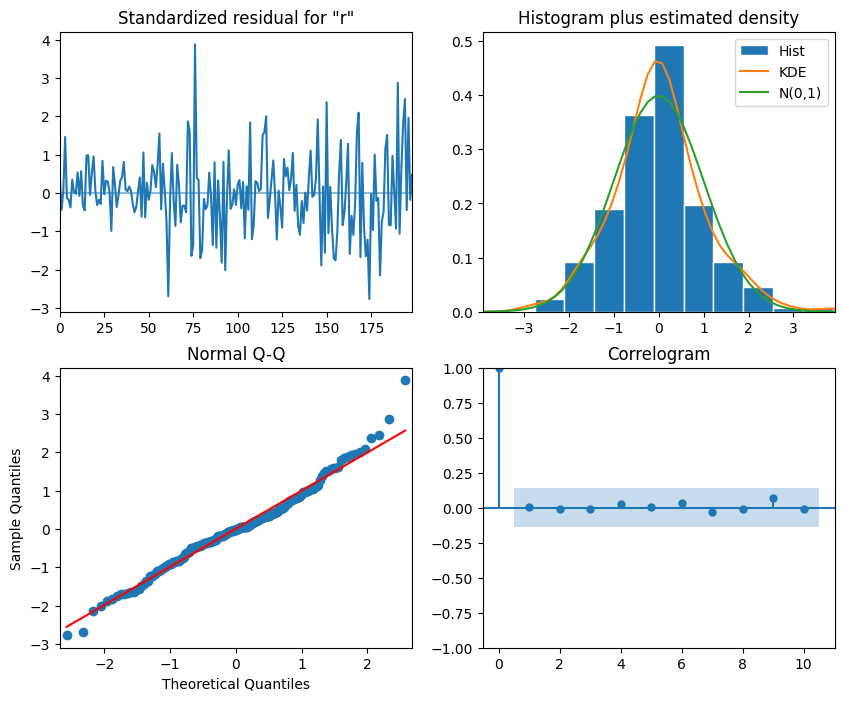

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8));

モデルの残差がホワイトノイズに似ている

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residual = best_model_fit.resid
result_df = acorr_ljungbox(residual, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,0.091422,0.762377
2,0.197976,0.905754
3,0.200038,0.977583
4,1.258379,0.868397
5,1.259141,0.939079
6,1.286324,0.972406
7,1.477787,0.983069
8,1.487681,0.992911
9,1.860910,0.993481
10,1.867707,0.997257


すべてのp値が0.05よりも大きいため、残差は独立して無相関

モデルを予測に使うことができる

In [ ]:
def rolling_forecast(
    endog: Union[pd.Series, np.ndarray],
    exog: Union[pd.Series, pd.DataFrame, np.ndarray, None],
    train_len: int,
    forecast_horizon: int,
    forecast_window: int,
    method: str
) -> list:

    end_point = train_len + forecast_window
    predictions = []

    for i in range(train_len, end_point, forecast_horizon):
        remaining = end_point - i
        current_horizon = min(forecast_horizon, remaining)

        if method == 'last':
            last_value = endog[:i].iloc[-1]
            if isinstance(last_value, pd.Series):
                last_value = last_value.values[0]
            pred = [last_value] * current_horizon

        elif method == 'SARIMAX':
            if exog is not None:
                exog_train = exog.iloc[:i] if isinstance(exog, (pd.Series, pd.DataFrame)) else exog[:i]
                exog_forecast = exog.iloc[i:i + current_horizon] if isinstance(exog, (pd.Series, pd.DataFrame)) else exog[i:i + current_horizon]
                model = SARIMAX(
                    endog[:i],
                    exog=exog_train,
                    order=(3,1,3),
                    seasonal_order=(0,0,0,4),
                    simple_differencing=False
                )
                res = model.fit(disp=False)
                forecast = res.get_prediction(start=i, end=i + current_horizon - 1, exog=exog_forecast)
            else:
                model = SARIMAX(
                    endog[:i],
                    order=(3,1,3),
                    seasonal_order=(0,0,0,4),
                    simple_differencing=False
                )
                res = model.fit(disp=False)
                forecast = res.get_prediction(start=i, end=i + current_horizon - 1)

            pred = forecast.predicted_mean.tolist()

        else:
            raise ValueError("Invalid method. Choose 'last' or 'SARIMAX'.")

        predictions.extend(pred)

    return predictions

In [ ]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = 1
WINDOW = len(target_test)

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON,WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW,'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13374.804004
197,13415.266,13366.865,13359.610878
198,13324.600,13415.266,13327.669990
199,13141.920,13324.600,13125.640656
200,12925.410,13141.920,12868.851644
201,12901.504,12925.410,12867.037259
202,12990.341,12901.504,13050.252013


In [ ]:
def mape(y_ture, y_pred):
    return np.mean(np.abs((y_ture - y_pred) / y_ture)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.255299305436995


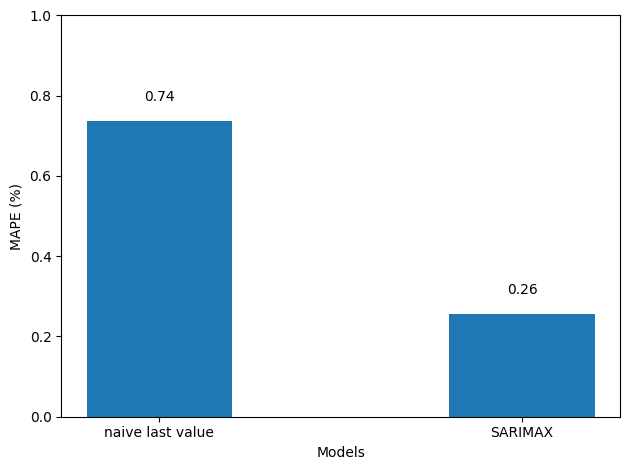

In [ ]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()